# Seven Segment OCR Using OpenCV

<div id="purpose">
    <h2>Purpose:</h2>To read an image file containing a picture of a seven segment display and determine which digits are being shown on the display
</div>

<h3>Examples of seven segment displays:</h3>
<div class="flex-container" style="display: flex;">
    <div><img src="https://media.boingboing.net/wp-content/uploads/2017/06/Alarm-clock-007.jpg" style="height: 150px;"></div>
    <div><img src = "https://hannainst.com/media/catalog/product/cache/1/image/9df78eab33525d08d6e5fb8d27136e95/h/i/hi991001_1.jpg" style="height: 150px;"></div>
    <div><img src="https://pim-resources.coleparmer.com/item/l/extech-lt300-precision-digital-light-meter-5051093.jpg" style="height: 150px;"></div>
    <div><img src="https://www.newsobserver.com/news/business/xq6smf/picture59297278/alternates/FREE_1140/160203smartmeter0032" style="height: 150px;"></div>
</div>
<br>
<div id="references">
    Credit to <a href="https://www.pyimagesearch.com"> PyImageSearch</a> for ideas/inspiration on this project
</div>

In [151]:
from matplotlib import pyplot as plt
from imutils import contours
import imutils
import cv2
import os
import random

<h2>Define an array that correlates the on/off values of a seven segment display to the displayed number</h2>

<img src="https://www.pyimagesearch.com/wp-content/uploads/2017/02/digit_reco_template.png" align="left" width="200px">

In [152]:
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

<h2>Pick a random image from the Test directory</h2>

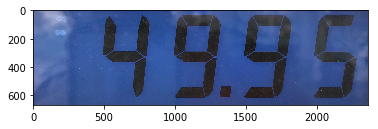

In [153]:
file = str(random.choice(os.listdir("Test/")))

#uncomment to test a specific file
#file = "0A37.jpg"

image = cv2.imread("Test/" + file)

plt.imshow(image)
plt.show()

<h2>Resize and perform transforms to the image</h2>

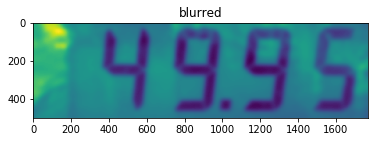

In [161]:
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (71, 71), 0)

plt.imshow(blurred)
plt.title('blurred')
plt.show()

<h2>Apply thresholding to the blurred image</h2>

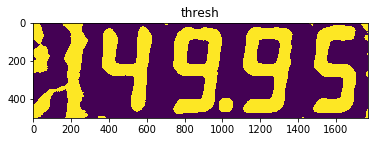

In [155]:
#thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
thresh = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,255,2)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(thresh)
plt.title('thresh')
plt.show()

<h2>Find contours in the blurred, thresholded image</h2>

In [156]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
digitCnts = []

<h2>Create bounding rectangles around each contour</h2>

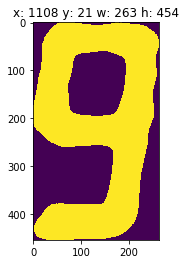

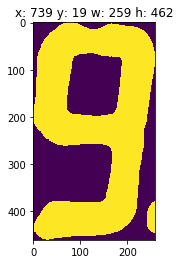

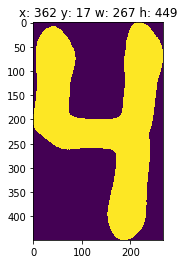

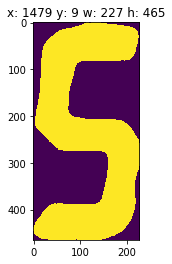

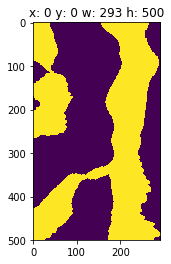

In [157]:
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    roi = thresh[y:y + h, x:x + w]


    # if the contour is sufficiently large, it must be a digit
    if w >= 50 and h >= 300:
        plt.imshow(roi)
        plt.title('x: ' + str(x) + ' y: ' + str(y) + ' w: ' + str(w) + ' h: ' + str(h))
        plt.show()
        digitCnts.append(c)

## Sort the contours from left to right

In [158]:
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

<h2>Finally, identify the image by:</h2>
<ol>
    <li>Chopping the image into 7 segments</li>
    <li>Loop over each segment and count the number of thresholded pixels in the segment</li>
    <li>Compute the area of the segment</li>
    <li>Compare the number of thresholded pixels in the segment to the area of the segment. If > 50%, then consider that segment "on"</li>
    <li>After looping through all segments in an image, lookup the segment on/off pattern in the DIGITS_LOOKUP array</li>

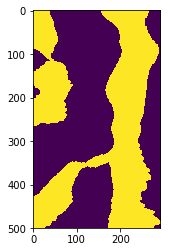

x: 0 y: 0 w: 293 h: 500
9
[1, 1, 1, 1, 0, 1, 1]


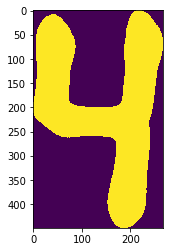

x: 362 y: 17 w: 267 h: 449
4
[0, 1, 1, 1, 0, 1, 0]


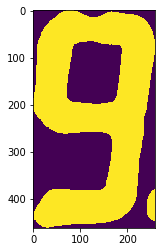

x: 739 y: 19 w: 259 h: 462
9
[1, 1, 1, 1, 0, 1, 1]


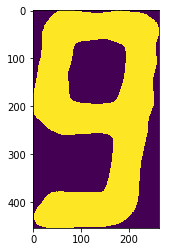

x: 1108 y: 21 w: 263 h: 454
9
[1, 1, 1, 1, 0, 1, 1]


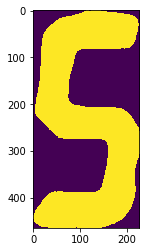

x: 1479 y: 9 w: 227 h: 465
5
[1, 1, 0, 1, 0, 1, 1]


In [159]:
digits = []
for c in digitCnts:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    if (w < 150 and w > 50):
        supp = 200 - w
        w = w + supp
        x = x - supp
    roi = thresh[y:y + h, x:x + w]
    plt.imshow(roi)
    plt.show()
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.35), int(roiH * 0.25))
    dHC = int(roiH * 0.05)

    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)

    # loop over the segments
    try:
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
            # extract the segment ROI, count the total number of
            # thresholded pixels in the segment, and then compute
            # the area of the segment
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)

            # if the total number of non-zero pixels is greater than
            # 50% of the area, mark the segment as "on"
            if total / float(area) > 0.5:
                on[i]= 1

        digit = DIGITS_LOOKUP[tuple(on)]
        digits.append(digit)
    except:
        try:
            for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
                # extract the segment ROI, count the total number of
                # thresholded pixels in the segment, and then compute
                # the area of the segment
                segROI = roi[yA:yB, xA:xB]
                total = cv2.countNonZero(segROI)
                area = (xB - xA) * (yB - yA)

                # if the total number of non-zero pixels is greater than
                # 50% of the area, mark the segment as "on"
                if total / float(area) > 0.4:
                    on[i]= 1

            # lookup the digit and draw it on the image
            digit = DIGITS_LOOKUP[tuple(on)]
            digits.append(digit)
        except:
            for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
                # extract the segment ROI, count the total number of
                # thresholded pixels in the segment, and then compute
                # the area of the segment
                segROI = roi[yA:yB, xA:xB]
                total = cv2.countNonZero(segROI)
                area = (xB - xA) * (yB - yA)

                # if the total number of non-zero pixels is greater than
                # 50% of the area, mark the segment as "on"
                if total / float(area) > 0.3:
                    on[i]= 1

            # lookup the digit and draw it on the image
            digit = DIGITS_LOOKUP[tuple(on)]
            digits.append(digit)
                    
    print('x: ' + str(x) + ' y: ' + str(y) + ' w: ' + str(w) + ' h: ' + str(h))
    print(digit)
    print(on)

In [160]:
print("".join(str(x) for x in digits))

94995
